### 1. Importing libraries

In [1]:
# File system and data handling
import os # For working with directories and file paths
import nibabel as nib # For loading .nii files as arrays

# Core PyTorch
import torch  # PyTorch base
import torch.nn.functional as F # Functional API for padding and other tensor operations
from torch.utils.data import Dataset # Dataset management

# TorchVision for image handling
from torchvision.utils import save_image # For saving tensor images to disk

# Visualization
import matplotlib.pyplot as plt # For visualizing images

import random # For random image selection
import numpy as np

### 2. Setting up device agnostic code

In [2]:
# Choose GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Padding

### 3. Loading and creating the dataset

In [3]:
image_paths = [] # Initialize an empty list to store paths of NIfTI image files
root_dir = '/kaggle/input/dataset/test_dataset' # Root directory

for folder in os.listdir(root_dir): # Loop over all files/folders inside test_dataset
    folder_path = os.path.join(root_dir, folder) # Create full path to each subfolder (e.g., test_dataset/checkerboard)
    
    if os.path.isdir(folder_path): # Check if it's actually a folder (not a file)
        image_folder = os.path.join(folder_path, 'image') # Construct path to the 'image' subfolder

        # Check if 'image' folder exists
        if os.path.exists(image_folder): 
            # Look for .nii or .nii.gz files inside the 'image' folder
            for file in os.listdir(image_folder):
                if file.endswith('.nii') or file.endswith('.nii.gz'):
                    image_path = os.path.join(image_folder, file)
                    image_paths.append(image_path)
        else:
            raise FileNotFoundError(f'Image not Found at {image_path}')
image_paths

['/kaggle/input/dataset/test_dataset/pattern_2/image/pattern_2.nii',
 '/kaggle/input/dataset/test_dataset/empty/image/empty.nii',
 '/kaggle/input/dataset/test_dataset/noise/image/noise.nii',
 '/kaggle/input/dataset/test_dataset/pattern_1/image/pattern_1.nii',
 '/kaggle/input/dataset/test_dataset/impulse/image/impulse.nii',
 '/kaggle/input/dataset/test_dataset/sphere/image/sphere.nii',
 '/kaggle/input/dataset/test_dataset/checkerboard/image/checkerboard.nii',
 '/kaggle/input/dataset/test_dataset/orientation/image/orientation.nii',
 '/kaggle/input/dataset/test_dataset/pattern_3/image/pattern_3.nii']

In [4]:
# Remove some of the images
del image_paths[:2]
image_paths.remove(image_paths[2])
image_paths.remove(image_paths[-1])
image_paths

['/kaggle/input/dataset/test_dataset/noise/image/noise.nii',
 '/kaggle/input/dataset/test_dataset/pattern_1/image/pattern_1.nii',
 '/kaggle/input/dataset/test_dataset/sphere/image/sphere.nii',
 '/kaggle/input/dataset/test_dataset/checkerboard/image/checkerboard.nii',
 '/kaggle/input/dataset/test_dataset/orientation/image/orientation.nii']

In [5]:
# Creating a custom dataset
class NiftiDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        '''
        Args:
            image_paths (list): List of paths to the NIfTI images
            transform (callable, optional): Optional transform to be applied on a sample.
        '''
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        '''
        Return the number of images in the dataset.
        '''
        return len(self.image_paths)

    def __getitem__(self, idx):
        '''
        Load an image, apply padding and transformations.
        '''
        # Get the path to the NIfTI file
        img_path = self.image_paths[idx]
        
        # Load the NIfTI file using nibabel
        nifti_img = nib.load(img_path)
        
        # Convert to NumPy array (3D)
        np_img = nifti_img.get_fdata()
        
        # Convert to tensor
        img_tensor = torch.tensor(np_img, dtype=torch.float32)

        # Apply any transformations if provided
        if self.transform:
            img_tensor = self.transform(img_tensor)
        
        return img_tensor

### 4. Defining Padding Classes

In [6]:
# Base class for all padding methods
class ImagePadding:
    def __init__(self, pad_size=50):
        self.pad_size = pad_size # Uniform padding on all sides

    # This is a placeholder method that will be overridden in subclasses
    def apply_padding(self, image: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError('Subclasses should implement this method.')

#### Subclasses for different Padding Types:

In [7]:
# Constant Value Padding (black by default)
class ConstantPadding(ImagePadding):
    def apply_padding(self, image):
        '''
        Apply Constant value padding (pad using a constant value)
        Default: 0
        '''
        return F.pad(image, pad=[self.pad_size]*4, mode='constant', value=0)
        # pad format = [left, right, top, bottom]
        # so: pad=[self.pad_size]* 4 expands to:
        # pad=[50, 50, 50, 50] if sel.pad_size = 50

In [8]:
# Nearest Value Padding (Replicate Padding)
class NearestPadding(ImagePadding):
    def apply_padding(self, image):
        '''
        Apply nearest value padding (pad using the nearest pixel)
        '''
        return F.pad(image, pad=[self.pad_size]*4, mode='replicate')

In [9]:
# Periodic/Tiling Padding
class PeriodicPadding(ImagePadding):
    def apply_padding(self, image):
        '''
        Apply Periodic padding (wrap-around the image edges).
        '''
        
        return F.pad(image, pad=[self.pad_size]*4, mode='circular')

In [10]:
# Mirror Padding (Excluding edge pixels)
class MirrorPadding(ImagePadding):
    def apply_padding(self, image):
        '''
        Apply Mirror padding excluding edge pixels
        '''
        return F.pad(image, pad=[self.pad_size]*4, mode='reflect')

### 7. Applying padding and Visualization

In [11]:
# Initialize dataset
dataset = NiftiDataset(image_paths)

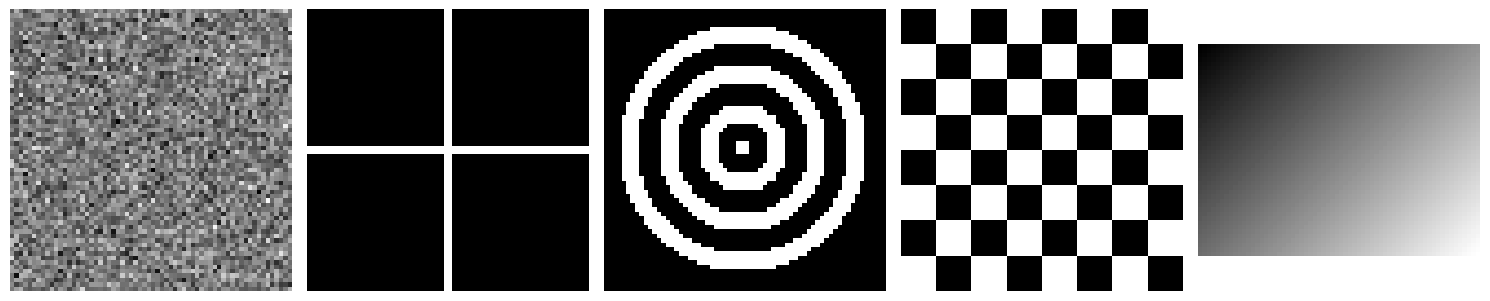

In [12]:
# Visualize the images in the dataset

fig, axs = plt.subplots(1, len(dataset), figsize=(15, 10))

for i in range(len(dataset)):
    axs[i].imshow(dataset[i][dataset[i].shape[0] // 2, :, : ], cmap='gray')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
def Padding_function(dataset, padding_class, num):
    """
    Selects `num` random images from the dataset, applies the given padding, 
    and returns lists of original and padded images.

    Args:
        dataset (Dataset): PyTorch-style dataset that returns image tensors.
        padding_class (ImagePadding): Instance of a padding class with an apply_padding() method.
        num (int): Number of images to randomly select and pad.

    Returns:
        original_images (list): List of original image tensors.
        padded_images (list): List of padded image tensors.
    """
    assert num <= len(dataset)

    # Randomly sample 'num' unique indices
    rand_indices = random.sample(range(len(dataset)), num)
    
    original_images = []
    padded_images = []
    
    for idx in rand_indices:
        original_img = dataset[idx] # Load image from dataset
        padded_img = padding_class.apply_padding(original_img)
        
        original_images.append(original_img)
        padded_images.append(padded_img)       
    
    return original_images, padded_images
    

In [14]:
def visualize_images(original_images, padded_images, title='Image'):
    '''
    Visualize 2 original and 2 corresponding padded images in a 2x2 grid.
    
    Args:
        original_images (list of Tensors): List of 2 original image tensors.
        padded_images (list of Tensors): List of 2 padded images tensors.
        title (str): Title prefix for each image.'''

    # Function expects 2 original and 2 padded images
    assert len(original_images) == 2 and len(padded_images) == 2

    # Empty list for middle 2D slices
    original_slices = []
    padded_slices = []
    
    for i in range(len(original_images)):
        orig_slice_idx = original_images[i].shape[0] // 2
        pad_slice_idx = padded_images[i].shape[0] // 2

        # This will give 2D slice
        original_slices.append(original_images[i][orig_slice_idx, :, :])
        padded_slices.append(padded_images[i][pad_slice_idx, :, :])

    # Create a 2x2 grid for visualization
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))

    # First column: Original images
    for i in range(2):
        axs[i, 0].imshow(original_slices[i].cpu().numpy(), cmap='gray')
        axs[i, 0].set_title(f'Original Image {i+1}')
        axs[i, 0].axis('off')

    # Second column: Padded Images
    for i in range(2):
        axs[i, 1].imshow(padded_slices[i].cpu().numpy(), cmap='gray')
        axs[i, 1].set_title(f'{title} Padded Image {i+1}')
        axs[i, 1].axis('off')

    plt.suptitle(f' Original vs {title} Padded Images', fontsize=15)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

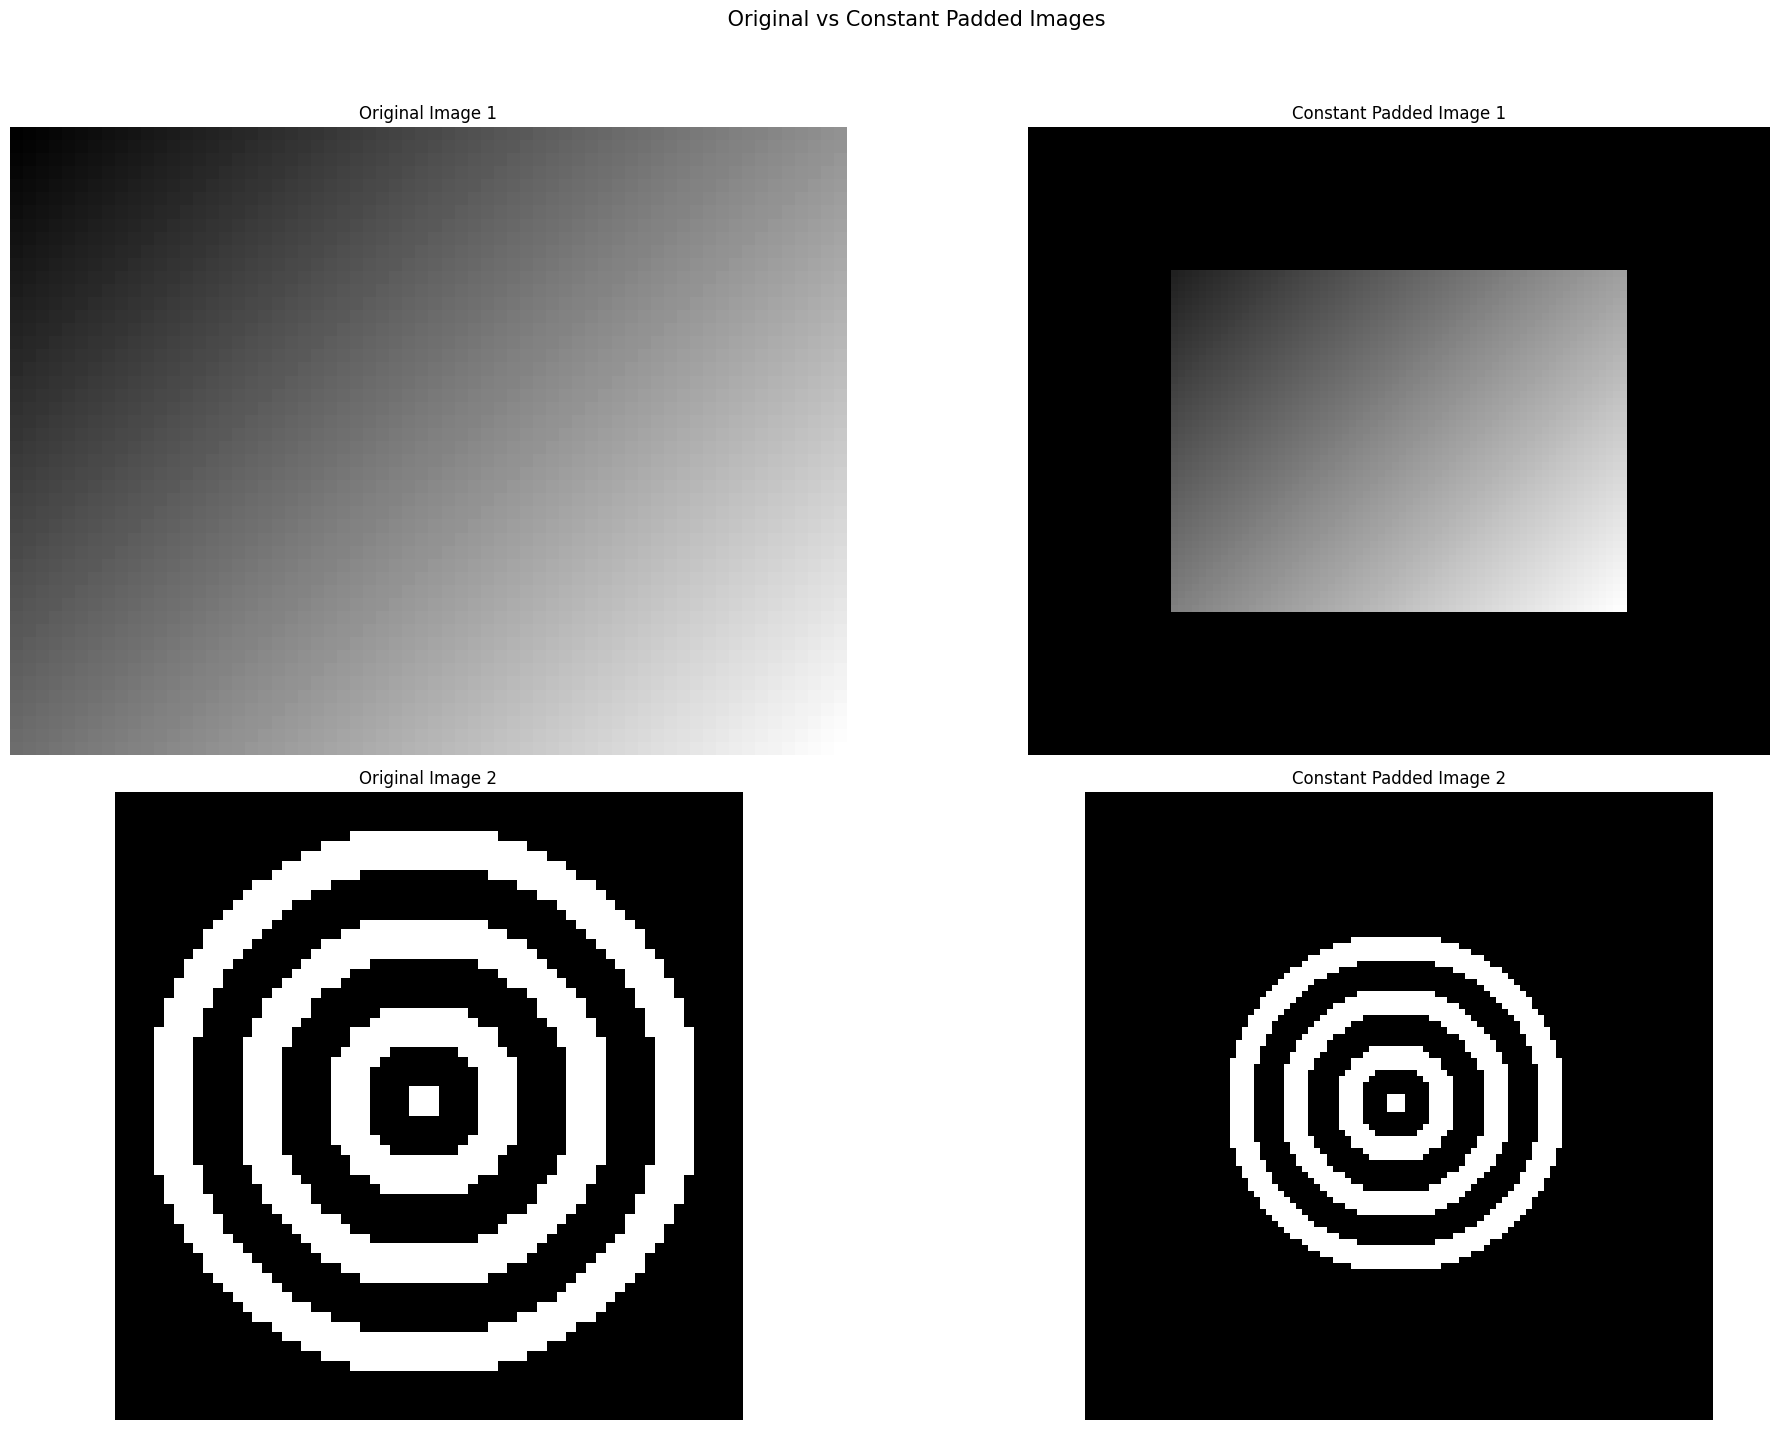

In [15]:
# Constant Value Padding

const_org_imgs, const_pad_imgs = Padding_function(dataset, ConstantPadding(pad_size=20), 2)
visualize_images(const_org_imgs, const_pad_imgs, 'Constant')

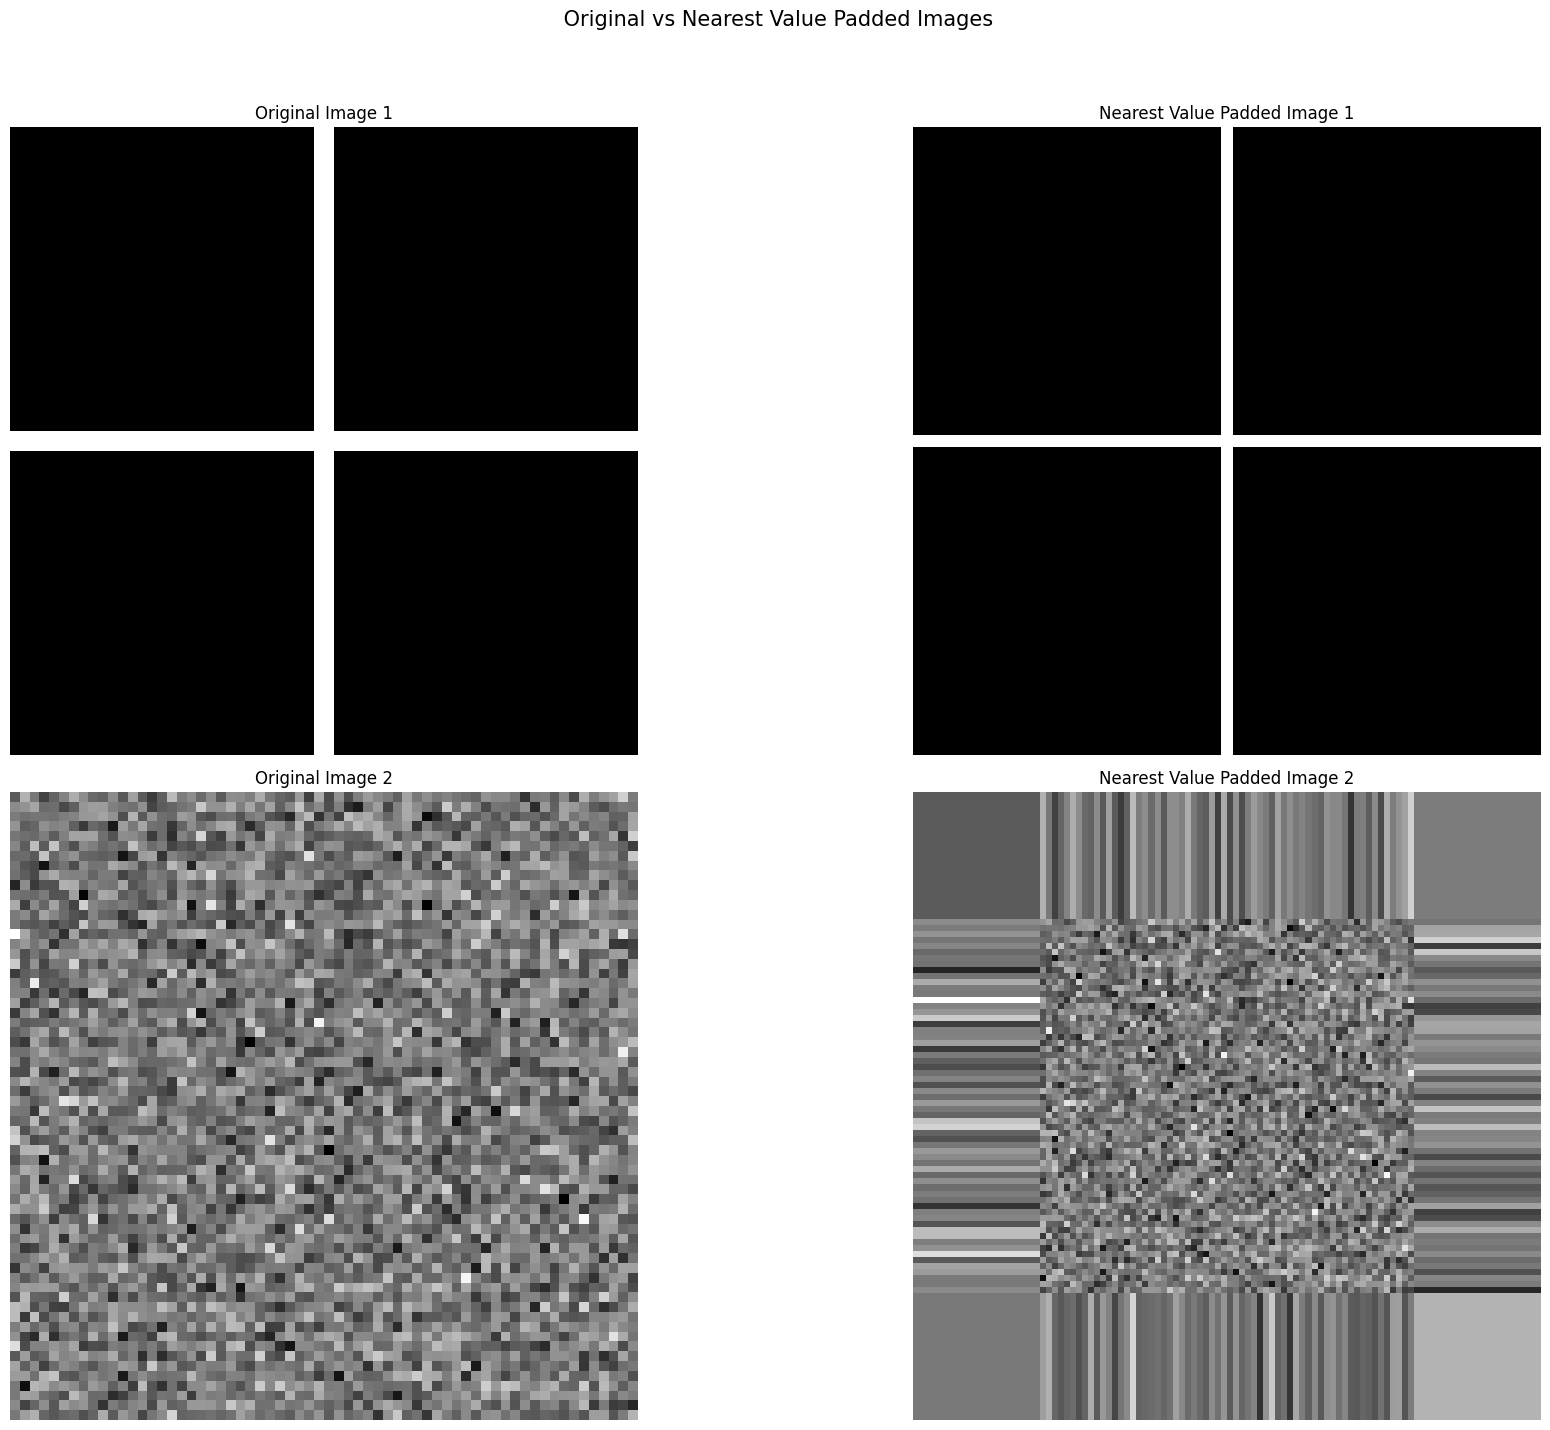

In [16]:
# Nearest Value Padding
nearest_org_imgs, nearest_pad_imgs = Padding_function(dataset, NearestPadding(pad_size=20), 2)

visualize_images(nearest_org_imgs, nearest_pad_imgs, 'Nearest Value')

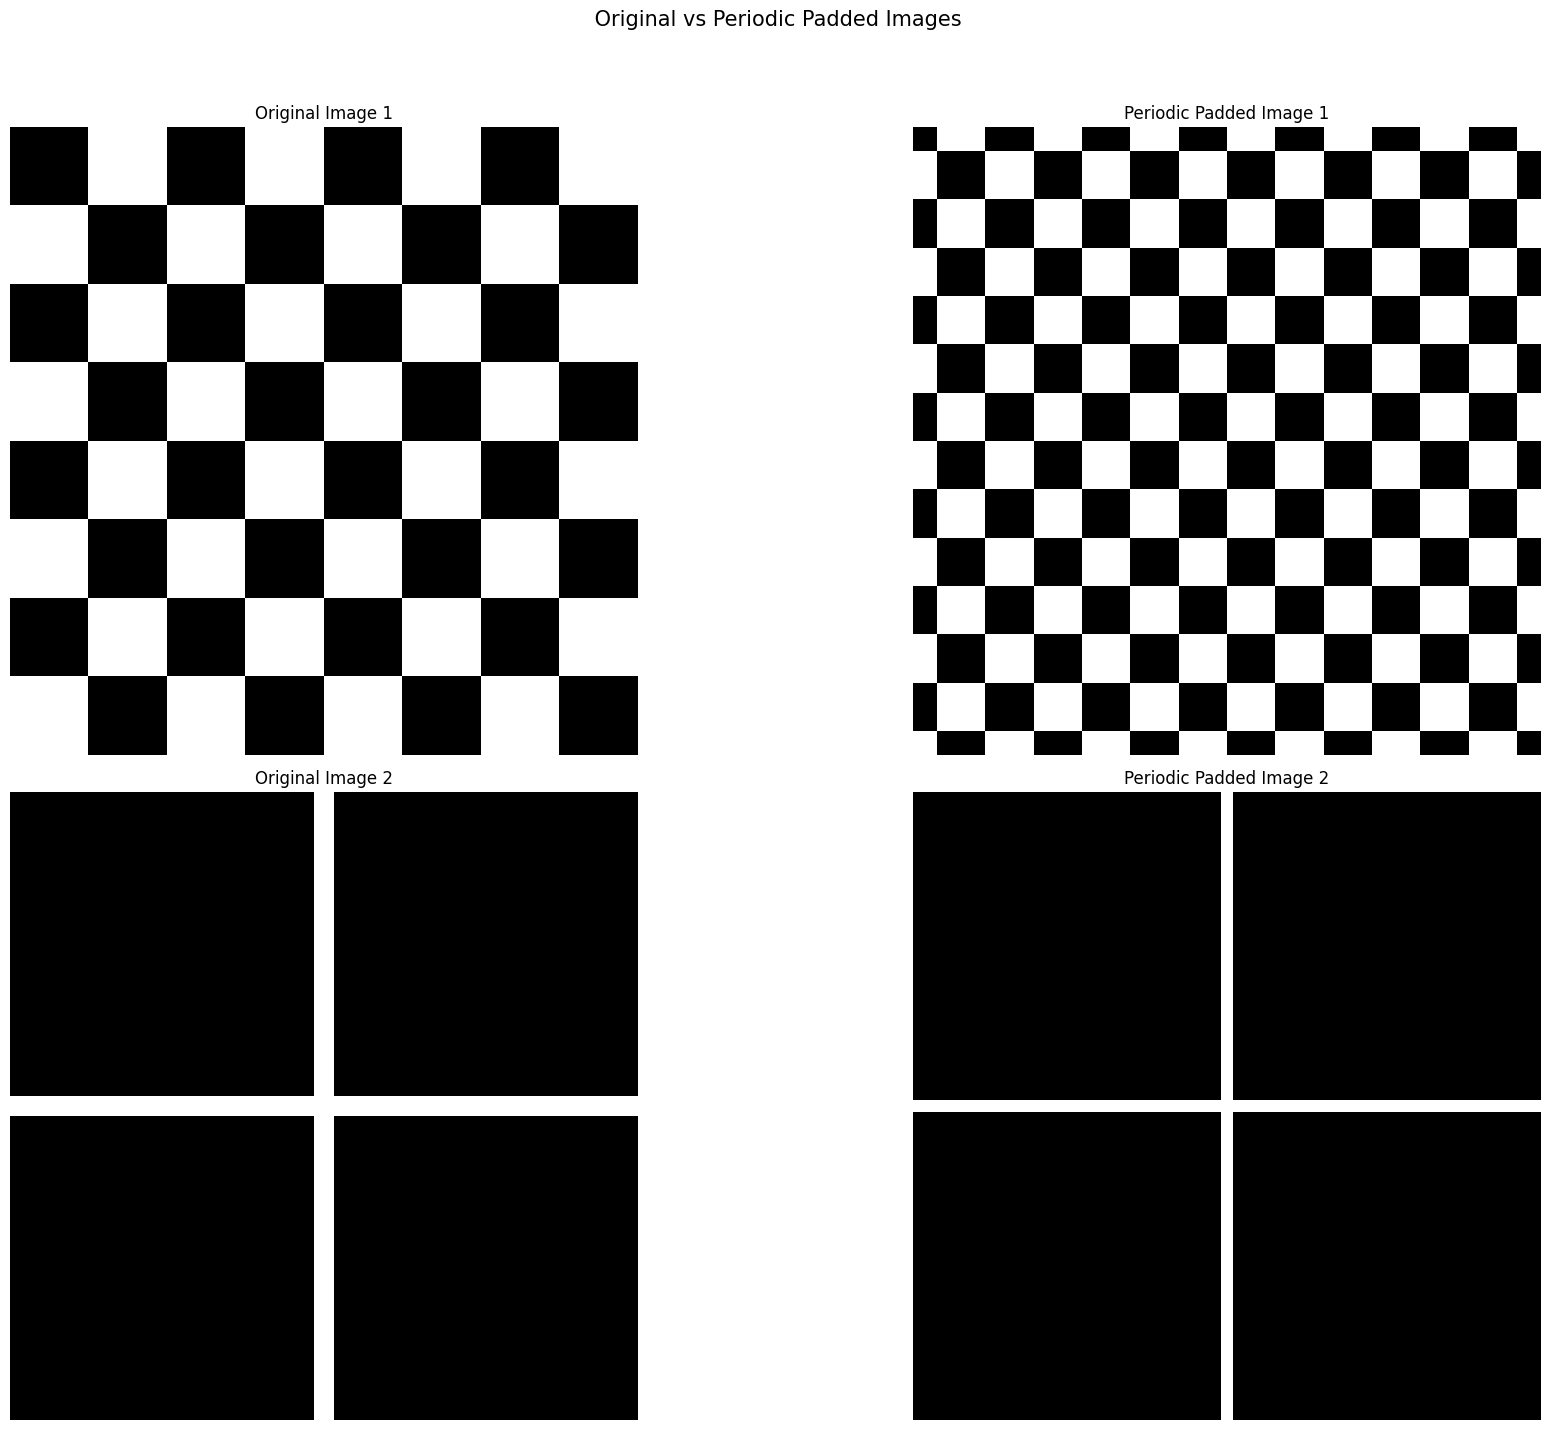

In [17]:
# Periodic Padding
periodic_org_imgs, periodic_pad_imgs = Padding_function(dataset, PeriodicPadding(pad_size=20), 2)

visualize_images(periodic_org_imgs, periodic_pad_imgs, 'Periodic')

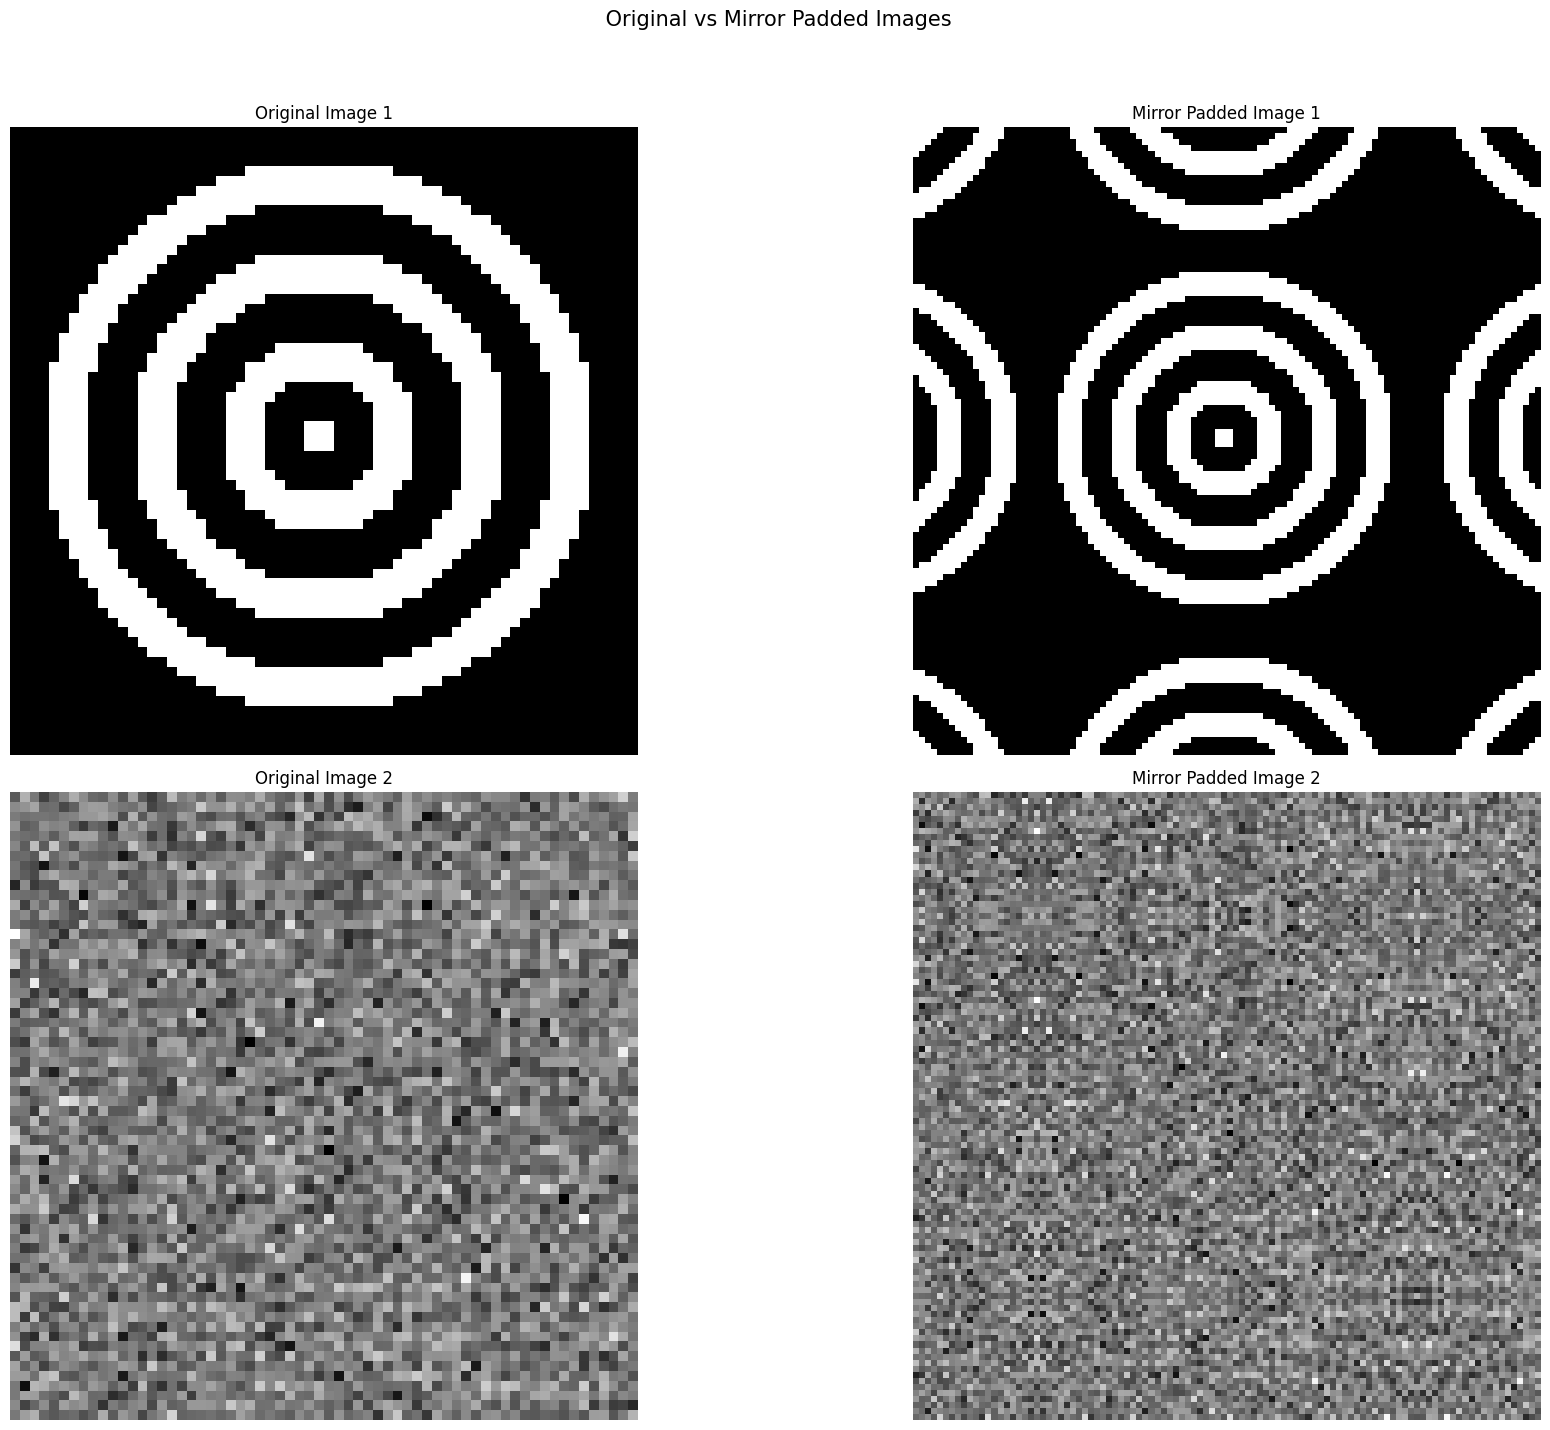

In [18]:
# Mirror Padding
mirror_org_imgs, mirror_pad_imgs = Padding_function(dataset, MirrorPadding(pad_size=20), 2)

visualize_images(mirror_org_imgs, mirror_pad_imgs, 'Mirror')

### 8. Saving Padded Images

In [19]:
def save_padded_images(padded_imgs, save_dir, prefix='padded'):
    os.makedirs(save_dir, exist_ok=True)
    for i, img_tensor in enumerate(padded_imgs):
        np_img = img_tensor.numpy()
        nifti_img = nib.Nifti1Image(np_img, affine=np.eye(4))
        nib.save(nifti_img, os.path.join(save_dir, f'{prefix}_{i}.nii.gz'))

In [20]:
padded_images = []

padded_images += const_pad_imgs + nearest_pad_imgs + periodic_pad_imgs + mirror_pad_imgs
print(len(padded_images))

save_dir = '/kaggle/working/padded_images/'

8


In [21]:
save_padded_images(padded_images, save_dir )